# Analysis of the Multi-Class Authorship Dataset

**Objective:** This notebook provides a comprehensive analysis of the `processed_xai_dataset.csv` file. The goal is to understand the characteristics of our three distinct classes—`human`, `ai_generated`, and `machine_translated`—before model training. A thorough understanding of the data is fundamental to any research-oriented NLP project.

## 1. Setup and Data Loading

First, we import the necessary libraries and load our dataset into a pandas DataFrame.

In [8]:
!pip install -r requirements.txt

You should consider upgrading via the '/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from collections import Counter

# Download nltk resources if not already present
nltk.download('punkt')

# Load the dataset
try:
    df = pd.read_csv('processed_xai_dataset.csv')
    print("Dataset loaded successfully!")
    print(f"Total samples: {len(df)}")
    df.head()
except FileNotFoundError:
    print("Error: 'processed_xai_dataset.csv' not found. Please run 'prepare_data.py' first.")

Dataset loaded successfully!
Total samples: 1500


[nltk_data] Downloading package punkt to /Users/deadbytes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Class Distribution

We'll start by confirming that our dataset is balanced across the three classes. A balanced dataset is crucial for preventing the model from becoming biased towards the majority class during training.

/var/folders/94/8jzz4l7x15lf_hlk8nqycnqm0000gn/T/ipykernel_12547/2368236036.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='source_label', data=df, palette='viridis')


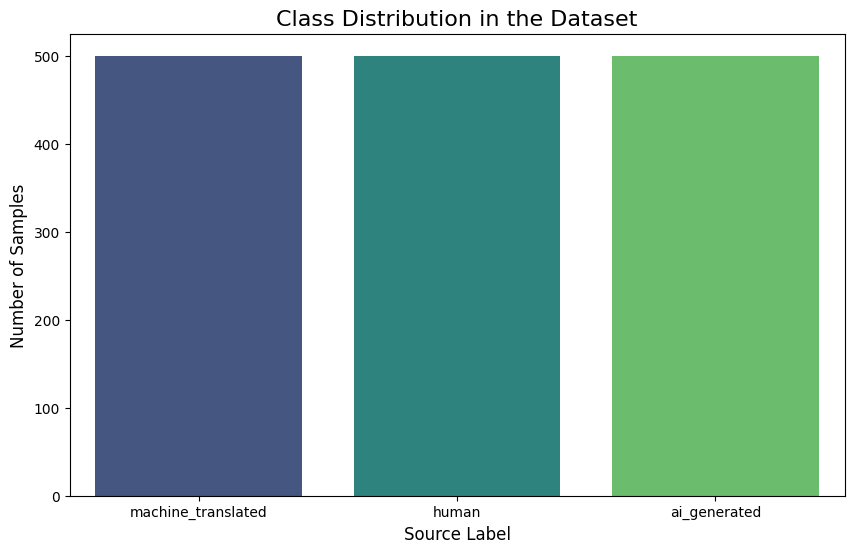

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='source_label', data=df, palette='viridis')
plt.title('Class Distribution in the Dataset', fontsize=16)
plt.xlabel('Source Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.show()

## 3. Text Length Analysis

Next, we analyze the distribution of text lengths (by word count) for each class. This can reveal if a specific source tends to produce longer or shorter text. Such a pattern could be a simple yet powerful feature for our classifier.

/var/folders/94/8jzz4l7x15lf_hlk8nqycnqm0000gn/T/ipykernel_12547/14866125.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source_label', y='word_count', data=df, palette='magma')


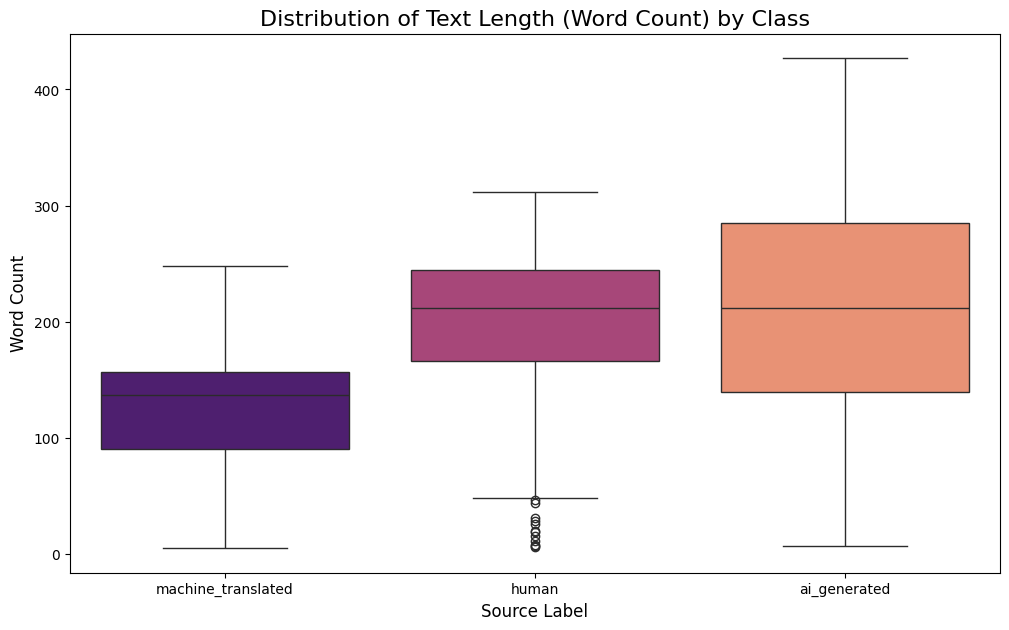

In [11]:
# Calculate word count for each text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 7))
sns.boxplot(x='source_label', y='word_count', data=df, palette='magma')
plt.title('Distribution of Text Length (Word Count) by Class', fontsize=16)
plt.xlabel('Source Label', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.show()

## 4. Vocabulary Richness Analysis (Type-Token Ratio)

Type-Token Ratio (TTR) is a measure of vocabulary diversity, calculated as the number of unique words (types) divided by the total number of words (tokens). A lower TTR can indicate more repetitive text. This analysis is key in NLP research to check for stylistic differences, as AI-generated text can sometimes be less lexically diverse than human writing.

/var/folders/94/8jzz4l7x15lf_hlk8nqycnqm0000gn/T/ipykernel_12547/695733205.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='source_label', y='ttr', data=df, palette='plasma')


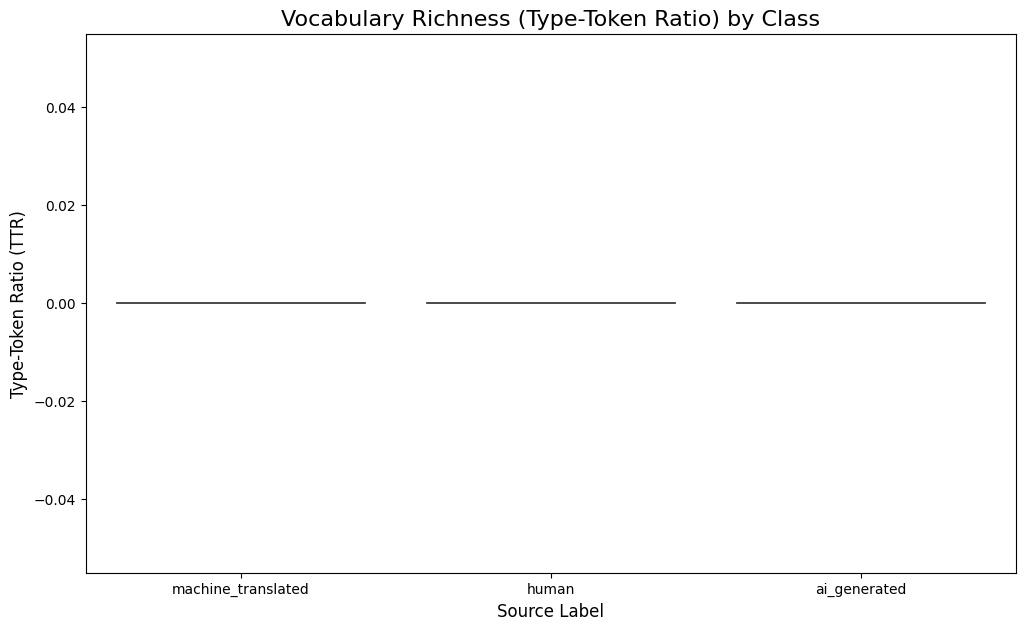

In [12]:
def calculate_ttr(text):
    try:
        tokens = nltk.word_tokenize(str(text).lower())
        if not tokens:
            return 0
        unique_tokens = set(tokens)
        return len(unique_tokens) / len(tokens)
    except Exception:
        return 0

df['ttr'] = df['text'].apply(calculate_ttr)

plt.figure(figsize=(12, 7))
sns.violinplot(x='source_label', y='ttr', data=df, palette='plasma')
plt.title('Vocabulary Richness (Type-Token Ratio) by Class', fontsize=16)
plt.xlabel('Source Label', fontsize=12)
plt.ylabel('Type-Token Ratio (TTR)', fontsize=12)
plt.show()

## 5. Top N-grams Analysis

Analyzing the most frequent n-grams (sequences of n words) can reveal characteristic phrases or stylistic patterns unique to each class. For example, an AI might overuse certain transitional phrases, or the machine translation might contain specific artifacts. We will examine the top 10 most common bigrams (2-word phrases) for each source.

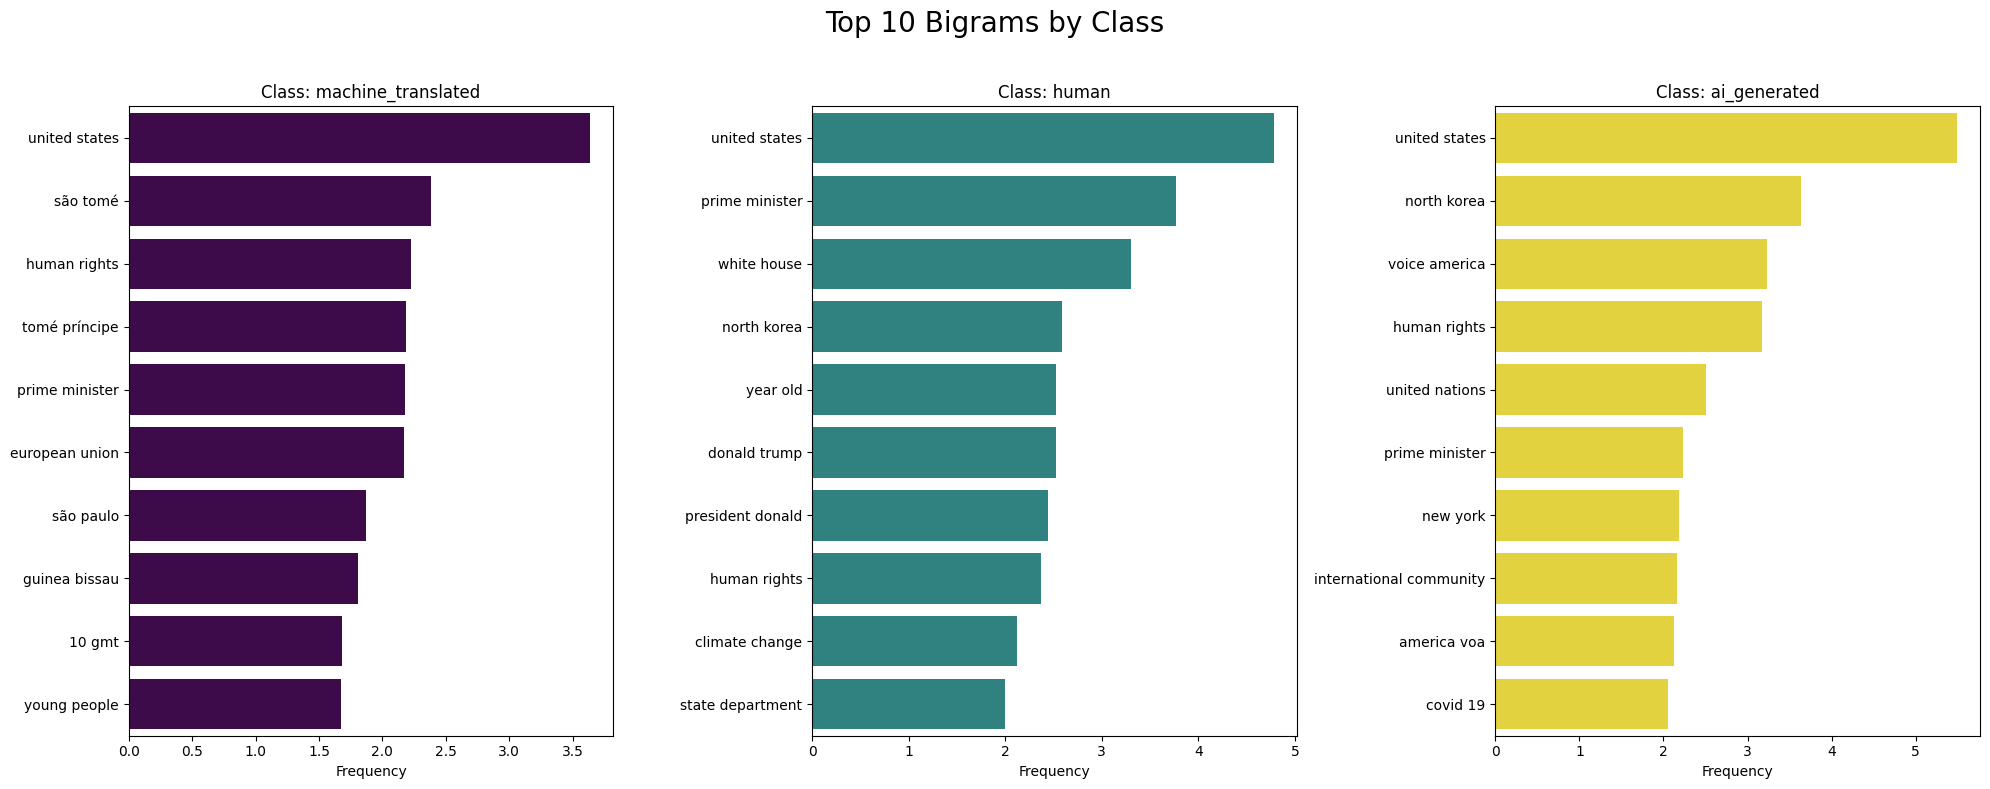

In [13]:
def get_top_ngrams(corpus, n=2, top_k=10):
    vec = TfidfVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Top 10 Bigrams by Class', fontsize=20)

colors = ['#440154', '#21908d', '#fde725']
labels = df['source_label'].unique()

for i, label in enumerate(labels):
    corpus = df[df['source_label'] == label]['text']
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=10)
    
    if not top_bigrams:
        continue
        
    x, y = zip(*top_bigrams)
    sns.barplot(ax=axes[i], x=list(y), y=list(x), color=colors[i])
    axes[i].set_title(f'Class: {label}')
    axes[i].set_xlabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 6. t-SNE Visualization of Text Embeddings

This is a powerful technique to visualize how separable our classes are in a high-dimensional space. We convert each text into a numerical vector using TF-IDF (Term Frequency-Inverse Document Frequency) and then use t-SNE to project these vectors down to 2D. 

If we see distinct clusters for each class, it's a strong sign that a machine learning model will be able to find patterns to distinguish them.

Vectorizing text with TF-IDF...
Applying t-SNE for dimensionality reduction... This may take a moment.


/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/deadbytes/Documents/radar-multilingual-Nlp/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/U

Plotting t-SNE results...


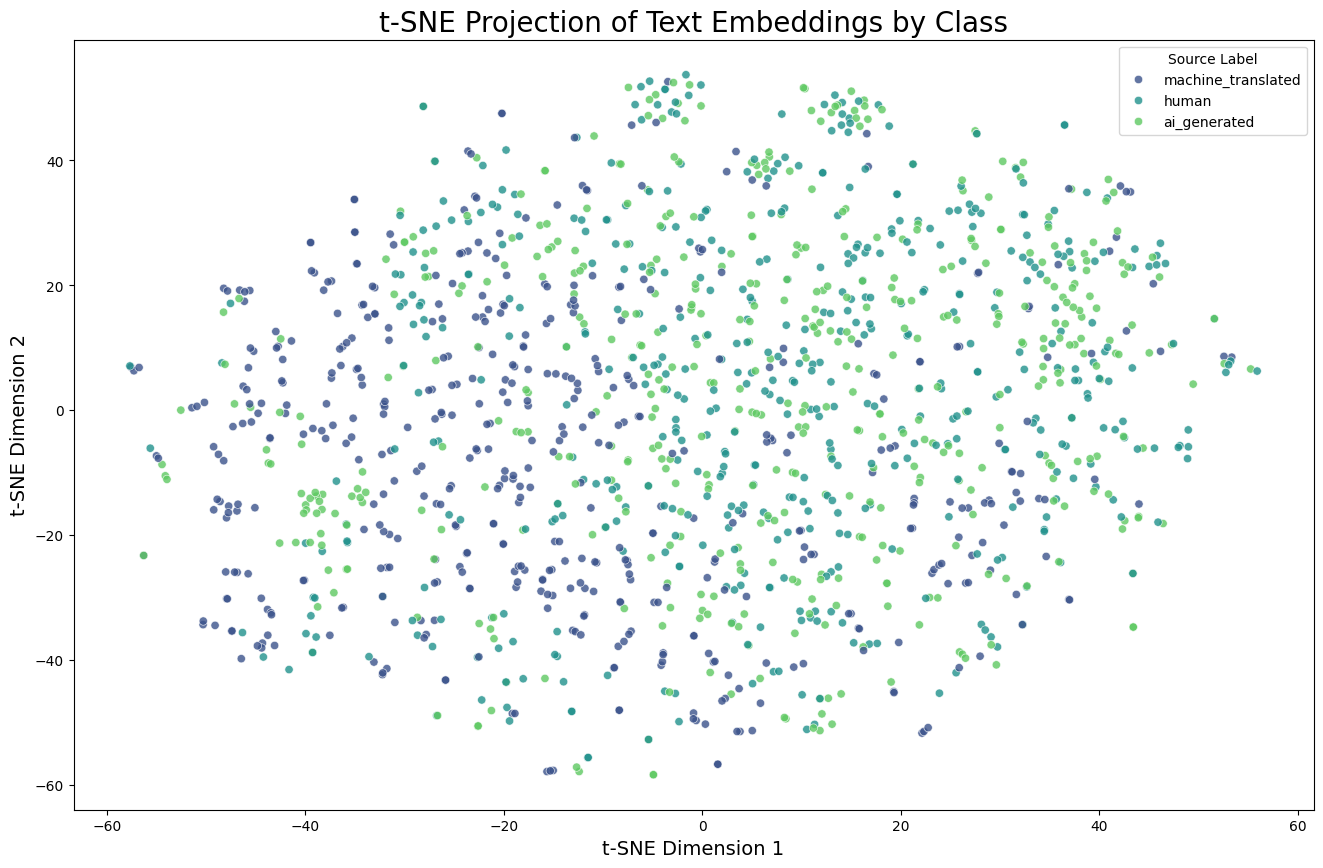

In [14]:
# Vectorize the text data using TF-IDF
print("Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['text'].astype('U')) # Ensure text is unicode

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction... This may take a moment.")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X.toarray())

df['tsne-2d-one'] = X_tsne[:,0]
df['tsne-2d-two'] = X_tsne[:,1]

# Plot the results
print("Plotting t-SNE results...")
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="source_label",
    palette=sns.color_palette("viridis", 3),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Projection of Text Embeddings by Class', fontsize=20)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(title='Source Label')
plt.show()